# Why hybrid method is better

- Dataset : AWA2
- OG Class : 40

### Step 1: Why and How 40 to 18 logic (Sementic similarity)

...

path test AWA2 = C:\ProjectWork\Basic_Python\Zero_shot_Learning\Dataset\artefact1\test

In [1]:
# lib's
import os
import numpy as np
import pandas as pd
import cv2
import pickle
import shutil

import csv
from sklearn.cluster import KMeans
# from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.utils import img_to_array  # Updated import
from keras.models import Model


import matplotlib.pyplot as plt
import seaborn as sns

### Step 2: Feture extraction by ResNet50 - (After getting 18 Classes)

In [15]:
# Variables
IMAGE_DIR = os.path.join('..', 'Dataset', 'artefact1', 'test_sun')
image_folder_path = IMAGE_DIR

# Parameters
IMG_SIZE = (224, 224)  # Image size for the CNN
N_CLUSTERS = 2 # Number of clusters

# Load pre-trained model and remove the top layers - Load the ResNet50 model with ImageNet weights
base_model = ResNet50(weights='imagenet')
# Get the second-to-last layer (Global Average Pooling 2D)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

# Model path
model_file_path = os.path.join('..', 'Models', 'test_model.pkl')

# cluster csv
c0_file_path = os.path.join('..', 'Dataset', 'C0_features.csv')
c1_file_path = os.path.join('..', 'Dataset', 'C1_features.csv')

In [3]:
# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, IMG_SIZE)  # Resize image
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)  # Preprocess for VGG16
    return image

# Function to save the model
def save_model(model, file_path):
    
    with open(file_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {file_path}")

# Function to load the model
def load_model(file_path):
    
    with open(file_path, 'rb') as f:
        model = pickle.load(f)
    print(f"Model loaded from {file_path}")
    return model

# Function to predict with the loaded model
def predict(model, data):
    return model.predict(data)

def extract_features_from_image():
    
    # Extract features from images
    image_paths, features, class_labels, class_number = [], [], [], []

    for class_folder in os.listdir(image_folder_path):
        class_folder_path = os.path.join(image_folder_path, class_folder)
        print(class_folder_path, class_folder_path.split('\\')[-1].split('.')[-1].replace('_', ' '))
        print(class_folder_path.split('\\')[-1])
        
        bird_lable = class_folder_path.split('\\')[-1].split('.')[-1].replace('_', ' ')
        bird_number = class_folder_path.split('\\')[-1].split('.')[0]
        
        #print(bird_lable, bird_number)
        
        # Ensure it's a directory
        if os.path.isdir(class_folder_path):
            for image_name in os.listdir(class_folder_path):
                image_path = os.path.join(class_folder_path, image_name)
                image_paths.append(image_path)  # Save the image path

                # Load and preprocess image
                image = load_and_preprocess_image(image_path)

                # Extract features
                feature = model.predict(image)
                features.append(feature.flatten())  # Flatten the feature array
                class_labels.append(bird_lable)
                class_number.append(bird_number)
                
    return (image_paths, features, class_labels, class_number)

def save_df(extract_features, CSV_PATH):
    features = np.array(extract_features[1])
    image_paths = np.array(extract_features[0])
    class_number = np.array(extract_features[3])
    class_labels = np.array(extract_features[2])

    df = pd.DataFrame(features)
    df['class_number'] = class_number
    df['class_labels'] = class_labels
    df['image_paths'] = image_paths
    display(df.head())
    
    df.to_csv(CSV_PATH, index=False)
    
    print(f"File saved to : {CSV_PATH}")
    
def train_kmean_model(N_CLUSTERS, features):
    
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters = N_CLUSTERS, random_state = 42)
    # clusters = kmeans.fit_predict(features) 
    # note : she using fit_predict which is wrong in this case need to use fit to train model
    kmeans.fit(features)
    
    return kmeans

In [4]:
# Print model summary
# model.summary()

# Save model
save_model(model, model_file_path)

# %%time
extract_features = extract_features_from_image()


Model saved to ..\Models\test_model.pkl
..\Dataset\artefact1\test_sun\bamboo_forest bamboo forest
bamboo_forest
1/1 [==============================] - 0s 200ms/step
..\Dataset\artefact1\test_sun\building_complex building complex
building_complex
1/1 [==============================] - 0s 212ms/step
..\Dataset\artefact1\test_sun\coast coast
coast
1/1 [==============================] - 0s 211ms/step
..\Dataset\artefact1\test_sun\garden garden
garden
1/1 [==============================] - 0s 216ms/step
..\Dataset\artefact1\test_sun\market market
market
1/1 [==============================] - 0s 220ms/step
..\Dataset\artefact1\test_sun\ocean ocean
ocean
1/1 [==============================] - 0s 228ms/step
..\Dataset\artefact1\test_sun\office office
office
1/1 [==============================] - 0s 205ms/step
..\Dataset\artefact1\test_sun\shopping_mall shopping mall
shopping_mall
1/1 [==============================] - 0s 209ms/step


In [4]:
# Save dataframe
CSV_PATH = os.path.join('..', 'Dataset', 'images_extract_features.csv')
# save_df(extract_features, CSV_PATH)

In [5]:
# apply PCA

data = pd.read_csv(CSV_PATH)
X = data.iloc[:,:2048]  
# y = data[['class_labels']] 
# X


# In order to visualize in 2D graph I will use PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_fit = pca.fit_transform(X)

df_pca = pd.DataFrame(data=pca_fit, columns=['PCA1', 'PCA2'])
df_pca['class_labels'] = data[['class_labels']] 
display(df_pca.head())

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_pca[['PCA1', 'PCA2']])

# Create a new DataFrame with scaled features
scaled_df = df_pca[['PCA1', 'PCA2']].copy()
scaled_df[['PCA1', 'PCA2']] = scaled_features
scaled_df['class_labels'] = data[['class_labels']] 

display(scaled_df.head())

,PCA1,PCA2,class_labels
0,-1.237365,17.420850,bamboo forest
1,1.430550,28.239178,bamboo forest
2,0.147216,12.851296,bamboo forest
3,4.507595,17.209780,bamboo forest
4,4.252647,23.463295,bamboo forest


,PCA1,PCA2,class_labels
0,0.368336,0.758444,bamboo forest
1,0.424022,1.000000,bamboo forest
2,0.397236,0.656413,bamboo forest
3,0.488248,0.753731,bamboo forest
4,0.482926,0.893362,bamboo forest


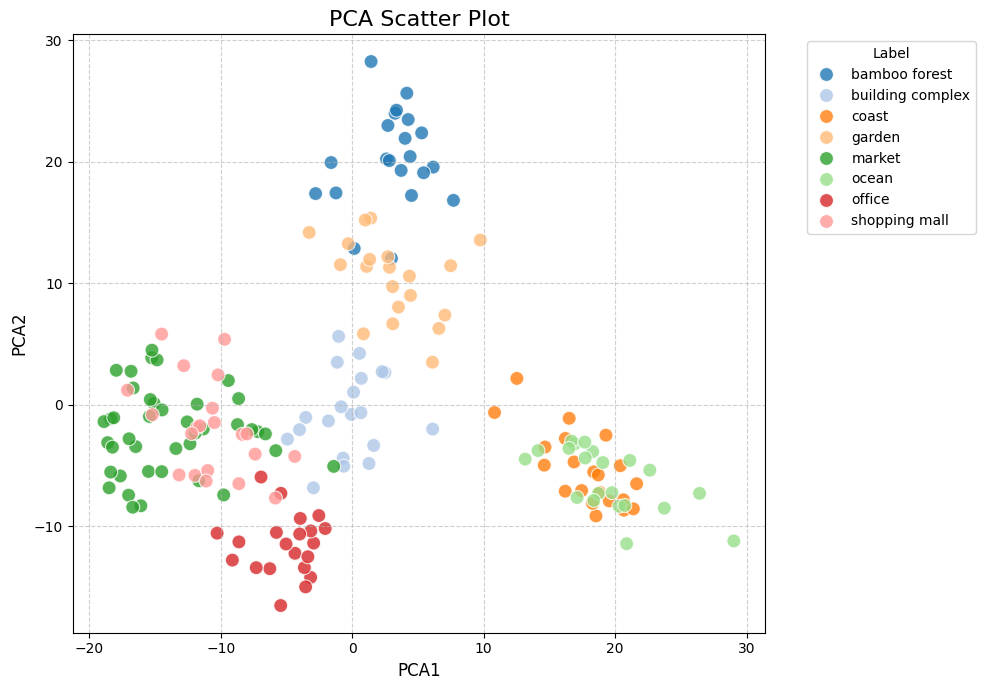

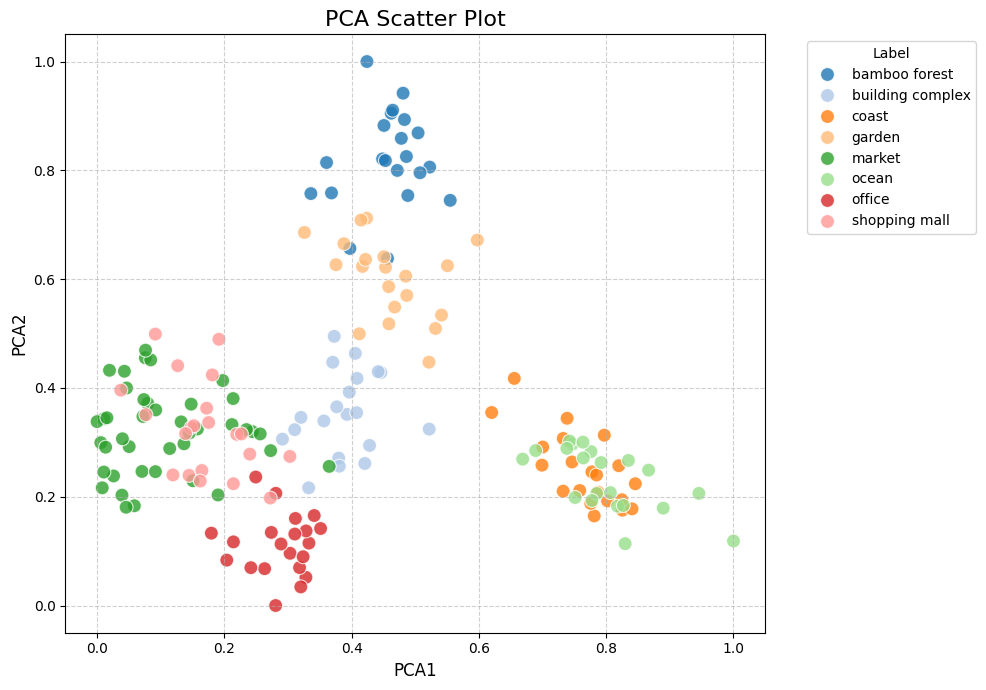

In [6]:
def plot_pca(dataframe):
    """
    Plots a 2D PCA scatter plot with points colored by their labels.

    Args:
        dataframe (pd.DataFrame): A DataFrame containing 'pca1', 'pca2', and 'label' columns.

    Returns:
        None
    """
#     if not {'pca1', 'pca2', 'label'}.issubset(dataframe.columns):
#         raise ValueError("DataFrame must contain 'pca1', 'pca2', and 'label' columns.")
    
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        data=dataframe,
        x='PCA1',
        y='PCA2',
        hue='class_labels',
        palette='tab20',
        s=100,
        alpha=0.8
    )
    plt.title('PCA Scatter Plot', fontsize=16)
    plt.xlabel('PCA1', fontsize=12)
    plt.ylabel('PCA2', fontsize=12)
    plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Plot PCA
plot_pca(df_pca)

plot_pca(scaled_df)

In [7]:
# Convert features to numpy array
features = scaled_df.iloc[:,:2]

# Train Kmean model
clusters = train_kmean_model(N_CLUSTERS, features)
print(clusters)

# Save the model
file_path = os.path.join('..', 'Models', 'kmean_model.pkl')
save_model(clusters, file_path)

# Load the model
clusters = load_model(file_path)

# Predict with the loaded model
y_pred_clusters = predict(clusters, features)
print(y_pred_clusters)

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=42)
Model saved to ..\Models\kmean_model.pkl
Model loaded from ..\Models\kmean_model.pkl
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 1 0 1 1 0 1 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1]


In [8]:
scaled_df['y_pred_clusters'] = y_pred_clusters
scaled_df.head()

,PCA1,PCA2,class_labels,y_pred_clusters
0,0.368336,0.758444,bamboo forest,0
1,0.424022,1.000000,bamboo forest,0
2,0.397236,0.656413,bamboo forest,0
3,0.488248,0.753731,bamboo forest,0
4,0.482926,0.893362,bamboo forest,0


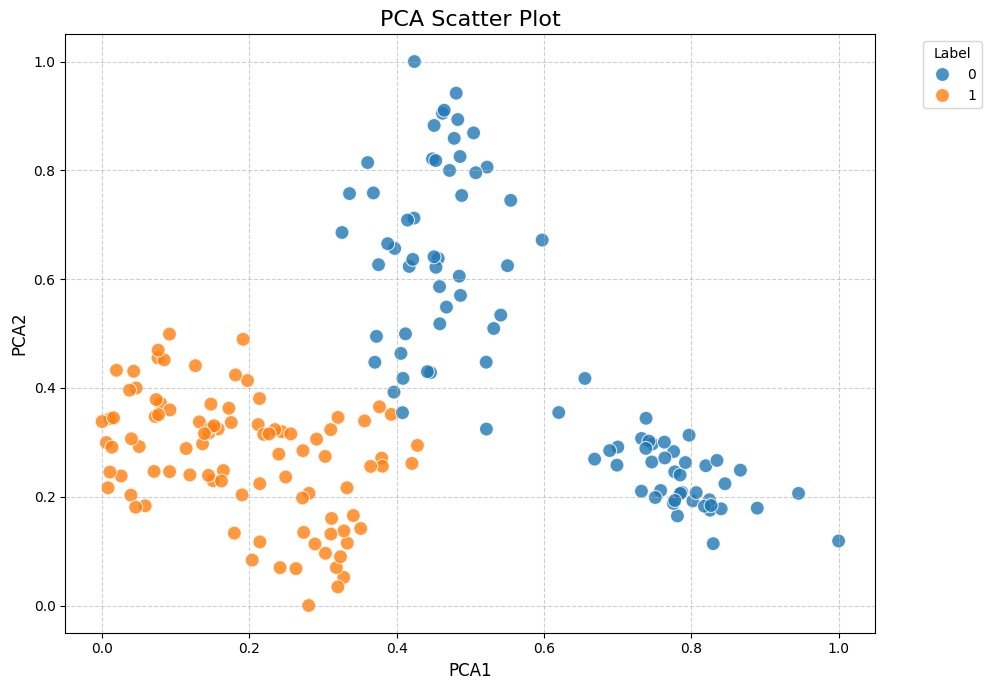

In [9]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=scaled_df,
    x='PCA1',
    y='PCA2',
    hue='y_pred_clusters',
    palette='tab10',
    s=100,
    alpha=0.8
)
plt.title('PCA Scatter Plot', fontsize=16)
plt.xlabel('PCA1', fontsize=12)
plt.ylabel('PCA2', fontsize=12)
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [10]:
# Group by Class and Cluster and count the occurrences
grouped = scaled_df.groupby(['class_labels', 'y_pred_clusters']).size().unstack(fill_value=0)

# Add a new column to determine the predominant cluster
grouped['finalCluster'] = (grouped[0] < grouped[1]).astype(int)

grouped

y_pred_clusters,0,1,finalCluster
class_labels,,,
bamboo forest,21,0,0
building complex,9,11,1
coast,21,0,0
garden,20,0,0
market,0,41,1
ocean,21,0,0
office,0,21,1
shopping mall,0,21,1


In [11]:
# Save the results to a new CSV file
output_path = os.path.join('..', 'Dataset', 'grouped.csv')  # Specify your output file path here
grouped.to_csv(output_path)
grouped = pd.read_csv(output_path)
print(grouped.columns, '\n')

# Filter the classes based on the predominant cluster
# cluster_0_classes = grouped[grouped['finalCluster'] == 0]['class_labels'].tolist()
# cluster_1_classes = grouped[grouped['finalCluster'] == 1]['class_labels'].tolist()
cluster_0_classes = grouped.loc[grouped['finalCluster'] == 0, 'class_labels'].tolist()
cluster_1_classes = grouped.loc[grouped['finalCluster'] == 1, 'class_labels'].tolist()

# Print the lists
print("Classes in Cluster 0: ", cluster_0_classes, "\n")
print("Classes in Cluster 1: ", cluster_1_classes)

Index(['class_labels', '0', '1', 'finalCluster'], dtype='object') 

Classes in Cluster 0:  ['bamboo forest', 'coast', 'garden', 'ocean'] 

Classes in Cluster 1:  ['building complex', 'market', 'office', 'shopping mall']


In [12]:
scaled_df['cluster'] = scaled_df['class_labels'].apply(lambda x: 0 if x in cluster_0_classes else 1)
scaled_df

,PCA1,PCA2,class_labels,y_pred_clusters,cluster
0,0.368336,0.758444,bamboo forest,0,0
1,0.424022,1.000000,bamboo forest,0,0
2,0.397236,0.656413,bamboo forest,0,0
3,0.488248,0.753731,bamboo forest,0,0
4,0.482926,0.893362,bamboo forest,0,0
...,...,...,...,...,...
181,0.239962,0.278348,shopping mall,1,1
182,0.164665,0.248183,shopping mall,1,1
183,0.091474,0.498982,shopping mall,1,1
184,0.162115,0.228826,shopping mall,1,1


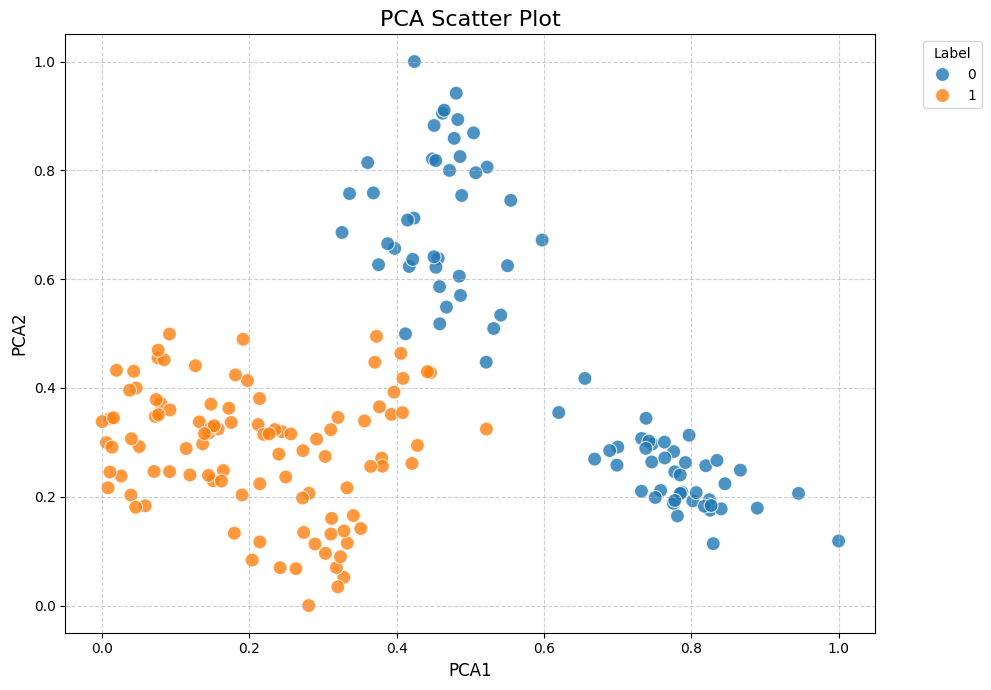

In [13]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=scaled_df,
    x='PCA1',
    y='PCA2',
    hue='cluster',
    palette='tab10',
    s=100,
    alpha=0.8
)
plt.title('PCA Scatter Plot', fontsize=16)
plt.xlabel('PCA1', fontsize=12)
plt.ylabel('PCA2', fontsize=12)
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# # cluster 1: bear, cow, gorilla, monkey, ox
# cl = ['bear', 'cow', 'gorilla', 'monkey', 'ox'] 
# filtered_df1 = scaled_df[~scaled_df['class_labels'].isin(cl)]
# # filtered_df1

# filtered_df2 = scaled_df[scaled_df['class_labels'].isin(cl)]
# # filtered_df1


# plot_pca(filtered_df1)
# plot_pca(filtered_df2)

In [14]:
print("Classes in Cluster 0: ", cluster_0_classes, "\n")
print("Classes in Cluster 1: ", cluster_1_classes)

Classes in Cluster 0:  ['bamboo forest', 'coast', 'garden', 'ocean'] 

Classes in Cluster 1:  ['building complex', 'market', 'office', 'shopping mall']


In [16]:
data = pd.read_csv(CSV_PATH)
# X = data.iloc[:,:2048]  
# y = data[['class_labels']] 

data_c0 = data[data['class_labels'].isin(cluster_0_classes)]
data_c1 = data[data['class_labels'].isin(cluster_1_classes)]

data_c0.to_csv(c0_file_path, index=False)
data_c1.to_csv(c1_file_path, index=False)

data_c0 = pd.read_csv(c0_file_path)
data_c1 = pd.read_csv(c1_file_path)

print(f"{data.shape} \n{data_c0.shape} \n{data_c1.shape}")

(186, 2051) 
(83, 2051) 
(103, 2051)


In [17]:
data_c0

,0,1,2,3,4,5,6,7,8,9,...,2041,2042,2043,2044,2045,2046,2047,class_number,class_labels,image_paths
0,0.613302,0.467846,0.000000,1.889513,0.338253,0.060944,0.314203,0.456034,0.034871,1.777760,...,1.014497,0.072491,0.276810,0.558005,0.433095,1.271364,0.015967,bamboo_forest,bamboo forest,..\Dataset\artefact1\test_sun\bamboo_forest\su...
1,1.547887,0.410747,0.021249,0.010061,0.099218,0.009004,0.463575,0.152164,0.187955,0.795889,...,0.789560,1.181744,0.053716,0.796936,0.000000,0.114520,0.833661,bamboo_forest,bamboo forest,..\Dataset\artefact1\test_sun\bamboo_forest\su...
2,0.439314,0.000000,0.000000,0.687923,0.088920,0.146684,0.029379,0.397146,1.799030,0.939984,...,0.297943,0.451395,0.184122,0.937071,0.712098,0.131019,0.220288,bamboo_forest,bamboo forest,..\Dataset\artefact1\test_sun\bamboo_forest\su...
3,0.460866,0.000349,0.000000,0.503212,0.029784,0.000000,0.056455,0.071213,0.772938,0.984681,...,0.000000,0.023162,0.000000,1.309778,0.075693,0.075637,0.000000,bamboo_forest,bamboo forest,..\Dataset\artefact1\test_sun\bamboo_forest\su...
4,0.271558,0.000000,0.004049,0.509029,0.947342,0.116473,0.219058,0.007594,0.422806,1.307817,...,0.296676,0.016763,0.051910,0.659805,0.255592,0.000000,0.002317,bamboo_forest,bamboo forest,..\Dataset\artefact1\test_sun\bamboo_forest\su...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,0.326957,0.027106,0.107343,0.000000,0.067000,0.000000,0.809342,0.258387,0.576837,0.613920,...,0.036235,0.016895,0.744852,0.029059,1.149204,0.057259,0.175958,ocean,ocean,..\Dataset\artefact1\test_sun\ocean\sun_aeuxci...
79,0.712265,0.000000,0.416866,0.000000,0.065658,0.097037,0.000000,0.050987,0.128026,0.847065,...,0.033534,0.000000,0.067560,0.000000,4.873747,0.037154,0.028961,ocean,ocean,..\Dataset\artefact1\test_sun\ocean\sun_afjixg...
80,0.313869,0.003980,0.100445,0.086546,0.127929,0.000000,0.304246,0.259399,1.887096,0.293536,...,0.174024,0.842070,0.364140,0.001351,7.321042,0.000000,0.021717,ocean,ocean,..\Dataset\artefact1\test_sun\ocean\sun_afjtgm...
81,0.000245,0.000000,0.009786,0.000000,0.513692,0.183033,0.003505,0.519024,0.480631,0.275172,...,0.000000,0.189368,0.164335,0.000000,0.000000,0.000000,0.551971,ocean,ocean,..\Dataset\artefact1\test_sun\ocean\sun_agkwhh...


In [18]:
display(data_c0['class_labels'].value_counts())

display(data_c1['class_labels'].value_counts())

class_labels
bamboo forest    21
coast            21
ocean            21
garden           20
Name: count, dtype: int64

class_labels
market              41
office              21
shopping mall       21
building complex    20
Name: count, dtype: int64

In [21]:
# apply PCA
X = data_c0.iloc[:,:2048]  
# y = data_c0[['class_labels']] 
# X

# In order to visualize in 2D graph I will use PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_fit = pca.fit_transform(X)

df_pca = pd.DataFrame(data=pca_fit, columns=['PCA1', 'PCA2'])
df_pca['class_labels'] = data_c0[['class_labels']] 
display(df_pca.head())

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_pca[['PCA1', 'PCA2']])

# Create a new DataFrame with scaled features
scaled_df = df_pca[['PCA1', 'PCA2']].copy()
scaled_df[['PCA1', 'PCA2']] = scaled_features
scaled_df['class_labels'] = data_c0[['class_labels']] 

display(scaled_df.head())

display(df_pca['class_labels'].value_counts())
display(scaled_df['class_labels'].value_counts())

,PCA1,PCA2,class_labels
0,-17.279665,4.751159,bamboo forest
1,-24.079117,18.178653,bamboo forest
2,-12.179913,1.153491,bamboo forest
3,-14.929857,3.106336,bamboo forest
4,-21.213143,12.339007,bamboo forest


,PCA1,PCA2,class_labels
0,0.136741,0.577806,bamboo forest
1,0.000000,0.885522,bamboo forest
2,0.239301,0.495358,bamboo forest
3,0.183997,0.540111,bamboo forest
4,0.057637,0.751695,bamboo forest


class_labels
bamboo forest    21
coast            21
ocean            21
garden           20
Name: count, dtype: int64

class_labels
bamboo forest    21
coast            21
ocean            21
garden           20
Name: count, dtype: int64

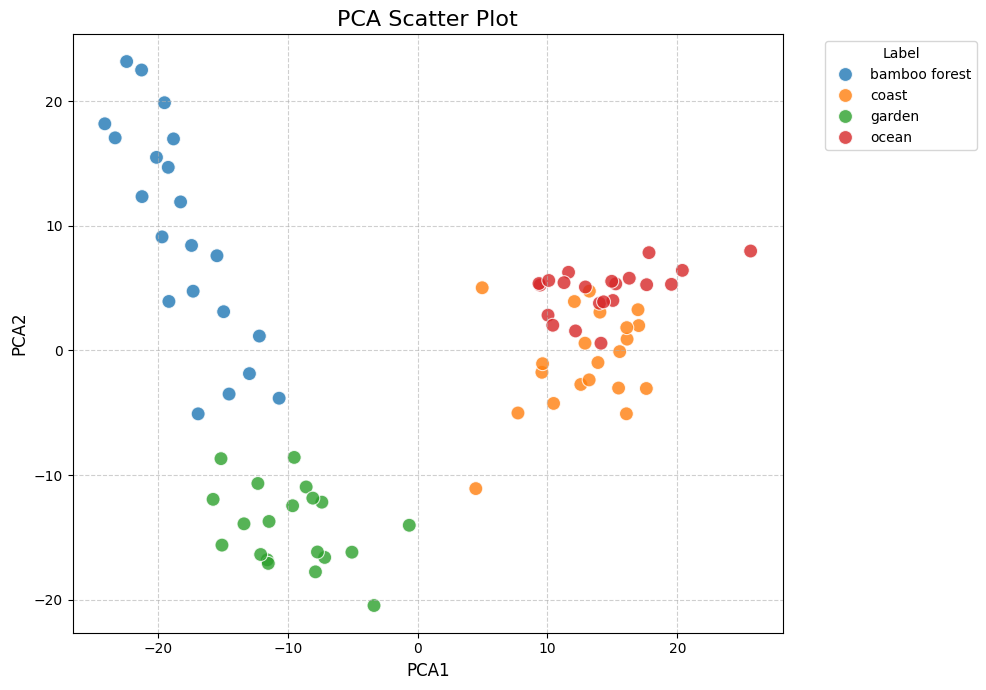

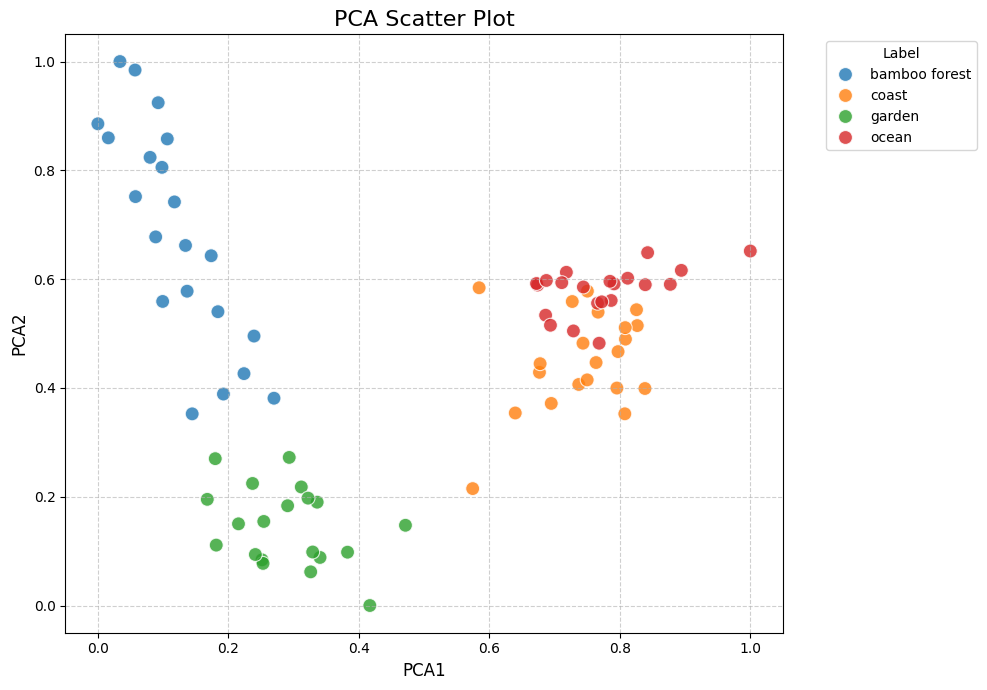

In [23]:
def plot_pca(dataframe):
    """
    Plots a 2D PCA scatter plot with points colored by their labels.

    Args:
        dataframe (pd.DataFrame): A DataFrame containing 'pca1', 'pca2', and 'label' columns.

    Returns:
        None
    """
#     if not {'pca1', 'pca2', 'label'}.issubset(dataframe.columns):
#         raise ValueError("DataFrame must contain 'pca1', 'pca2', and 'label' columns.")
    
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        data=dataframe,
        x='PCA1',
        y='PCA2',
        hue='class_labels',
        palette='tab10',
        s=100,
        alpha=0.8
    )
    plt.title('PCA Scatter Plot', fontsize=16)
    plt.xlabel('PCA1', fontsize=12)
    plt.ylabel('PCA2', fontsize=12)
    plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Plot PCA
plot_pca(df_pca)

plot_pca(scaled_df)

In [24]:
# apply PCA
X = data_c1.iloc[:,:2048]  
# y = data_c0[['class_labels']] 
# X

# In order to visualize in 2D graph I will use PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_fit = pca.fit_transform(X)

df_pca = pd.DataFrame(data=pca_fit, columns=['PCA1', 'PCA2'])
df_pca['class_labels'] = data_c1[['class_labels']] 
display(df_pca.head())

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_pca[['PCA1', 'PCA2']])

# Create a new DataFrame with scaled features
scaled_df = df_pca[['PCA1', 'PCA2']].copy()
scaled_df[['PCA1', 'PCA2']] = scaled_features
scaled_df['class_labels'] = data_c1[['class_labels']] 

display(scaled_df.head())

display(df_pca['class_labels'].value_counts())
display(scaled_df['class_labels'].value_counts())

,PCA1,PCA2,class_labels
0,-15.378758,-10.667207,building complex
1,-13.370208,-16.761453,building complex
2,-16.862647,-16.707814,building complex
3,-12.717366,-3.377077,building complex
4,-12.494490,-18.091679,building complex


,PCA1,PCA2,class_labels
0,0.036444,0.214988,building complex
1,0.085773,0.070489,building complex
2,0.000000,0.071760,building complex
3,0.101807,0.387842,building complex
4,0.107281,0.038948,building complex


class_labels
market              41
office              21
shopping mall       21
building complex    20
Name: count, dtype: int64

class_labels
market              41
office              21
shopping mall       21
building complex    20
Name: count, dtype: int64

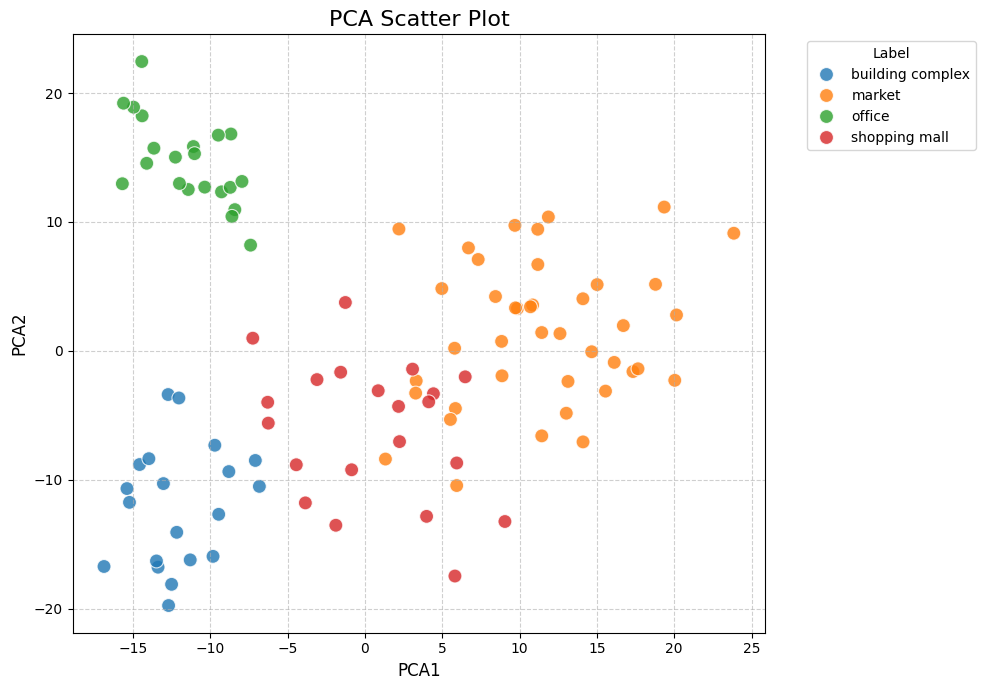

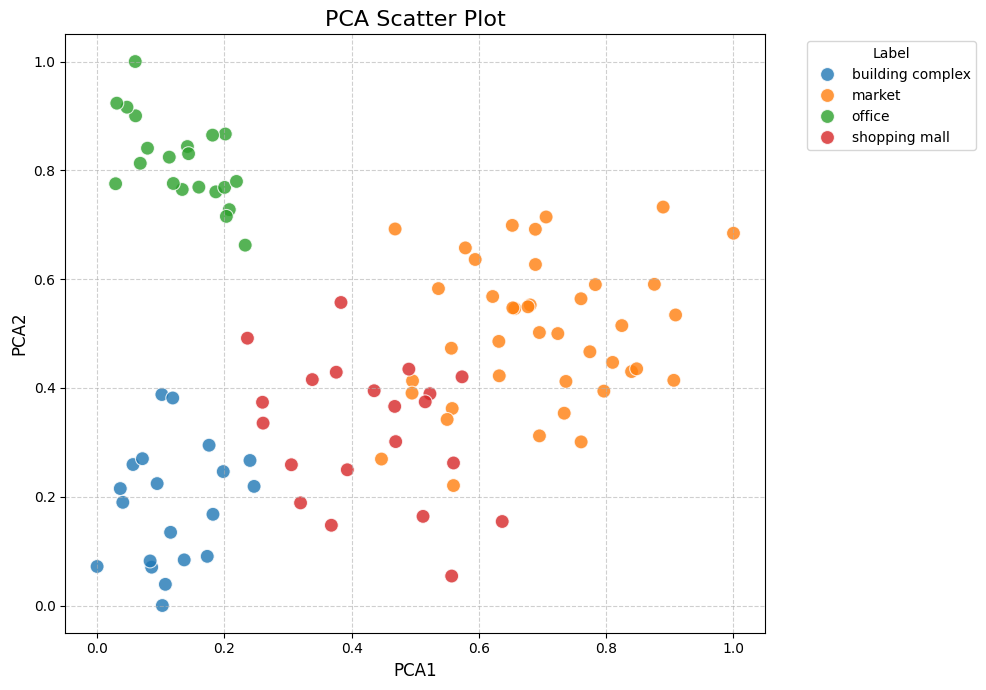

In [25]:
def plot_pca(dataframe):
    """
    Plots a 2D PCA scatter plot with points colored by their labels.

    Args:
        dataframe (pd.DataFrame): A DataFrame containing 'pca1', 'pca2', and 'label' columns.

    Returns:
        None
    """
#     if not {'pca1', 'pca2', 'label'}.issubset(dataframe.columns):
#         raise ValueError("DataFrame must contain 'pca1', 'pca2', and 'label' columns.")
    
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        data=dataframe,
        x='PCA1',
        y='PCA2',
        hue='class_labels',
        palette='tab10',
        s=100,
        alpha=0.8
    )
    plt.title('PCA Scatter Plot', fontsize=16)
    plt.xlabel('PCA1', fontsize=12)
    plt.ylabel('PCA2', fontsize=12)
    plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Plot PCA
plot_pca(df_pca)

plot_pca(scaled_df)

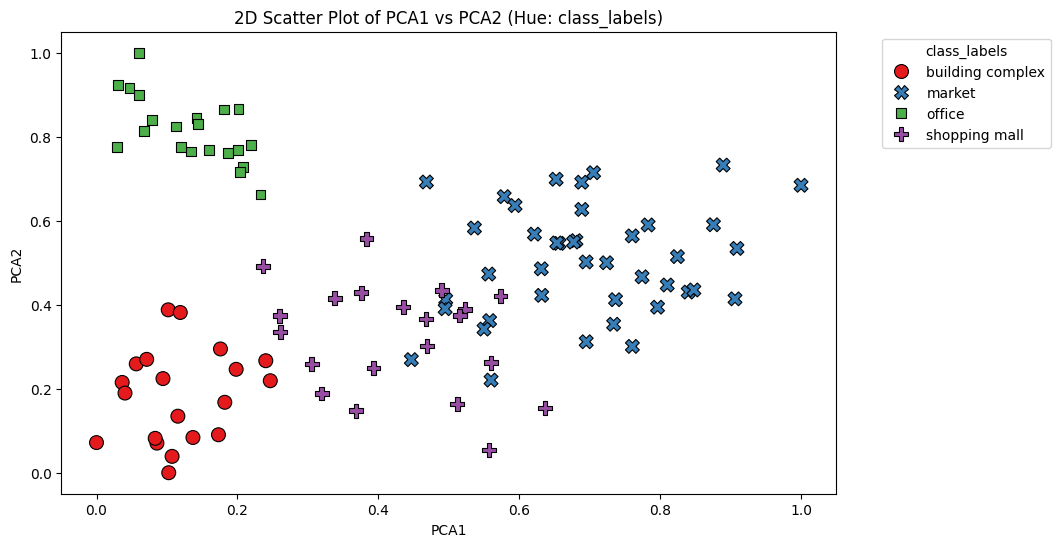

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_2d_scatter_with_hue(df, x_col, y_col, class_label_col):
    """
    Plots a 2D scatter plot with points colored based on class labels.

    :param df: Pandas DataFrame
    :param x_col: Column name for X-axis
    :param y_col: Column name for Y-axis
    :param class_label_col: Column name containing class labels (used for hue)
    """
    plt.figure(figsize=(10, 6))
    
    # Scatter plot with hue
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=class_label_col, style=class_label_col, palette="Set1", s=100, edgecolor='black')

    # Title and labels
    plt.title(f"2D Scatter Plot of {x_col} vs {y_col} (Hue: {class_label_col})")
    plt.xlabel(x_col)
    plt.ylabel(y_col)

    # Show the legend
    plt.legend(title=class_label_col, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

# Example Usage
# Creating a sample DataFrame
data = {
    'feature1': [1.2, 2.3, 3.1, 4.5, 5.8, 6.2, 7.4, 8.5],
    'feature2': [10, 15, 7, 25, 30, 35, 40, 50],
    'class_label': ['A', 'B', 'A', 'C', 'B', 'A', 'C', 'B']
}
df = pd.DataFrame(data)

# Call the function
plot_2d_scatter_with_hue(scaled_df, 'PCA1', 'PCA2', 'class_labels')


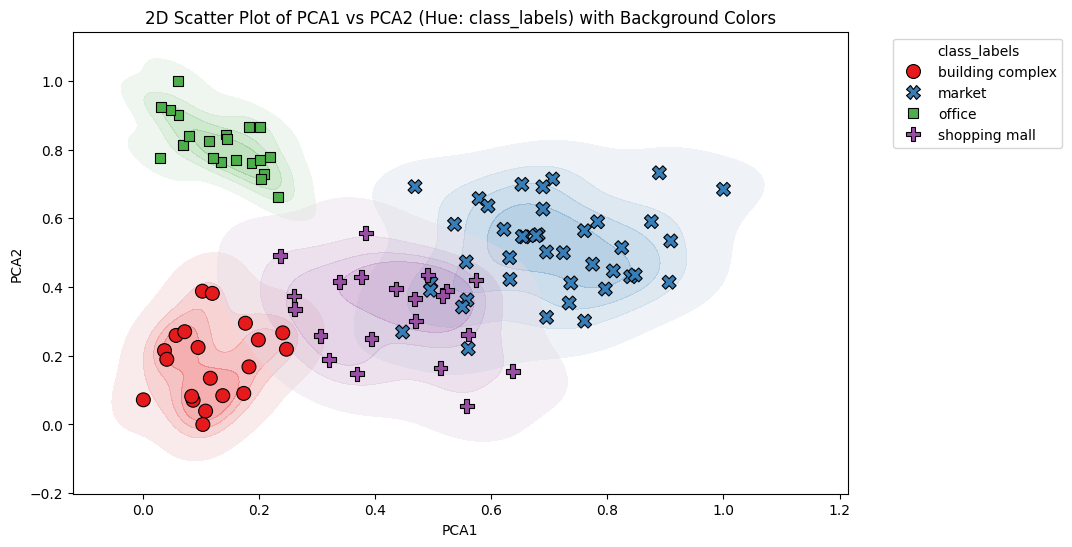

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_2d_scatter_with_hue_background(df, x_col, y_col, class_label_col):
    """
    Plots a 2D scatter plot with a soft KDE background for each class label.

    :param df: Pandas DataFrame
    :param x_col: Column name for X-axis
    :param y_col: Column name for Y-axis
    :param class_label_col: Column name containing class labels (used for hue)
    """
    plt.figure(figsize=(10, 6))
    
    unique_labels = df[class_label_col].unique()
    colors = sns.color_palette("Set1", len(unique_labels))

    # Plot KDE background for each class
    for label, color in zip(unique_labels, colors):
        subset = df[df[class_label_col] == label]
        if len(subset) > 1:  # KDE needs more than one point
            sns.kdeplot(x=subset[x_col], y=subset[y_col], cmap=sns.light_palette(color, as_cmap=True),
                        fill=True, alpha=0.4, levels=5, thresh=0.05)

    # Scatter plot with hue
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=class_label_col, style=class_label_col,
                    palette="Set1", s=100, edgecolor='black')

    # Title and labels
    plt.title(f"2D Scatter Plot of {x_col} vs {y_col} (Hue: {class_label_col}) with Background Colors")
    plt.xlabel(x_col)
    plt.ylabel(y_col)

    # Show the legend
    plt.legend(title=class_label_col, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()


# Call the function
plot_2d_scatter_with_hue_background(scaled_df, 'PCA1', 'PCA2', 'class_labels')
